# Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit,njit,float64,int32
import numba as nb
import pandas as pd
from derivative import dxdt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from derivative import dxdt

In [10]:
tiempo_vida_inicial = 20
tiempo_vida_maximo = 150            #Para que los resultados obtenidos se encuentren ligados a realidad biologica
pasos_integracion = 150             #Definicion de los pasos de integracion de algoritmo
alpha_damage_propagation = 0.050    #Tasa de propagacion de daño
coupling_factor = 0.089            #Factor de acoplamiento entre frailty index y gompertz
mortality_rate = 4.3*(10**(-5))     #Tasa de mortalidad
disease_rate = 0.02
initial_condition = 2.3

In [11]:
initial_condition = 2
def f(x, alpha_damage_propagation, disease_rate, t=None):
    return alpha_damage_propagation*x + disease_rate

def Runke_Kutta_Method(temporal_evolution:list, disease_rate):
    x = initial_condition                                         #Initial condition     
    frailty_index = np.empty((len(temporal_evolution)))
    for index, t in enumerate(temporal_evolution):
        frailty_index[index] = x
        k1 = h*f(x, alpha_damage_propagation, disease_rate, t=t)
        k2 = h*f(x+0.5*k1, alpha_damage_propagation, disease_rate, t=t +0.5*h)
        x += k2

    gompertz_law = mortality_rate*(frailty_index**(coupling_factor/alpha_damage_propagation))
    return frailty_index, gompertz_law, temporal_evolution

# USA Data Analysis

In [12]:
# Lectura datos fenomenologicos
with open('Mx_1x10/USA.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)

years_of_interes = ["1933-1939", "1940-1949","1950-1959", "1960-1969", "1970-1979","1980-1989", "1990-1999", "2000-2009", "2010-2019"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

In [13]:
data_40_60 = []
for year in years_of_interes:
    data_40_60.append(datos_generales[year][40:60])

In [271]:
tiempo_vida_inicial = 40
tiempo_vida_maximo = 60  

alpha_damage_propagation = 0.0478    #Tasa de propagacion de daño
coupling_factor = 0.0681            #Factor de acoplamiento entre frailty index y gompertz
mortality_rate = 4.3*(10**(-5))     #Tasa de mortalidad
disease_rate = 0.05
initial_condition = 31


h = (tiempo_vida_maximo-tiempo_vida_inicial)/pasos_integracion                                         #Pasos de integracion
temporal_evolution = np.arange(tiempo_vida_inicial,tiempo_vida_maximo,h) 
frailty_index_differential_equation,gompertz_law_differential_equation,temporal_evolution_differential_equation = Runke_Kutta_Method(temporal_evolution, disease_rate)


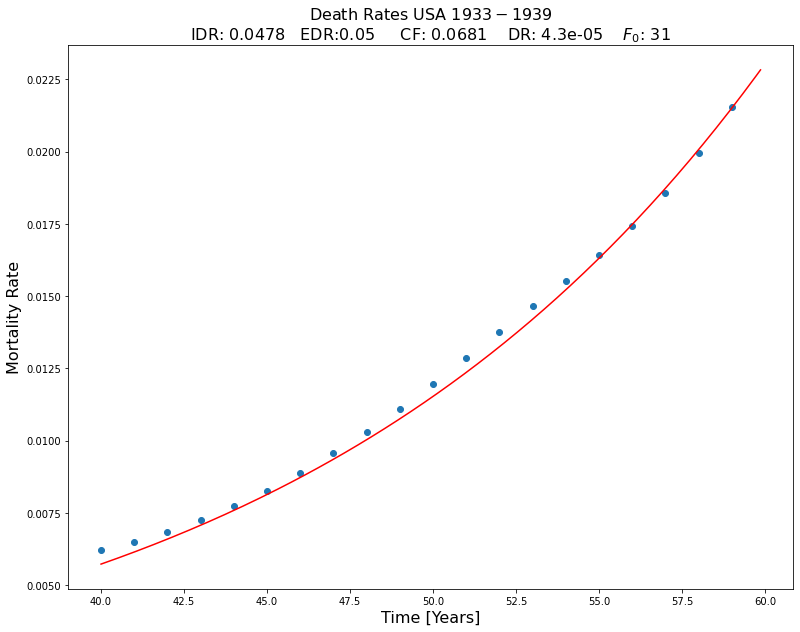

In [272]:
plt.figure(figsize=(13,10))
plt.title(r"Death Rates USA $1933-1939$" + "\n" + rf"IDR: {alpha_damage_propagation}   EDR:{disease_rate}     CF: {coupling_factor}    DR: {mortality_rate}    $F_0$: {initial_condition}" , fontsize = 16)
plt.xlabel(r"Time [Years]", fontsize = 16)
plt.ylabel(r"Mortality Rate", fontsize = 16)
plt.scatter(datos_generales["Ages"][40:60], data_40_60[0])
plt.plot(temporal_evolution, gompertz_law_differential_equation, color = "red")

In [ ]:
data_60_60 = []
for year in years_of_interes:
    data_40_60.append(datos_generales[year][40:60])

In [142]:
data_40_60[0]

array([0.006203, 0.006496, 0.00684 , 0.007246, 0.007723, 0.008274,
       0.008888, 0.009562, 0.010298, 0.011101, 0.011969, 0.012856,
       0.013751, 0.014645, 0.015526, 0.016411, 0.017414, 0.018581,
       0.019943, 0.021536])

In [14]:
datos_40_60_USA = datos_generales["1933-1939"][40:60]
edad = datos_generales["Ages"][40:60]

In [49]:
from scipy.interpolate import splrep, BSpline
tck = splrep(edad, datos_40_60_USA, s=0)
tck_s = splrep(edad, datos_40_60_USA, s= len(edad))
x = edad
y = datos_40_60_USA

In [51]:
data = datos_40_60_USA
temporal_evolution = edad
derivative_process = dxdt(data, temporal_evolution, kind="finite_difference", k=3)
beta_values = derivative_process/data
R_values = data/np.e**(beta_values*temporal_evolution)

In [56]:
print(np.mean(R_values))
print(np.mean(beta_values))

0.00048220682724107956
0.06524058844150435


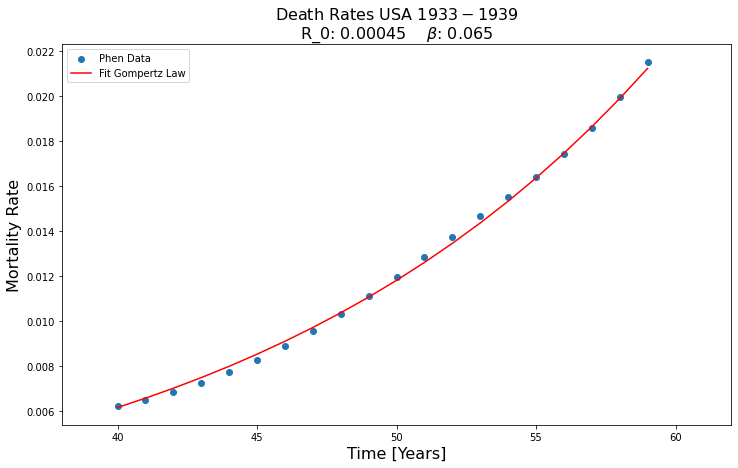

In [76]:
R_0 = 0.00045220682724107956
beta_exponencial = 0.06524058844150435

datos_expresion = R_0*(np.e**(beta_exponencial*edad))
plt.figure(figsize = (12,7))
plt.scatter(edad, datos_40_60_USA, label = "Phen Data")
plt.plot(edad, datos_expresion, color = "red", label = "Fit Gompertz Law")
plt.xlim(38,62)
plt.title(r"Death Rates USA $1933-1939$" + "\n" + rf"R_0: {round(R_0,5)}    $\beta$: {round(beta_exponencial, 3)}" , fontsize = 16)
plt.xlabel(r"Time [Years]", fontsize = 16)
plt.ylabel(r"Mortality Rate", fontsize = 16)
plt.legend()


In [6]:
tiempo_vida_inicial = 20
tiempo_vida_maximo = 150            #Para que los resultados obtenidos se encuentren ligados a realidad biologica
pasos_integracion = 150             #Definicion de los pasos de integracion de algoritmo
alpha_damage_propagation = 0.050    #Tasa de propagacion de daño
coupling_factor = 0.089            #Factor de acoplamiento entre frailty index y gompertz
mortality_rate = 4.3*(10**(-5))     #Tasa de mortalidad
disease_rate = 0.02
N_total_nodes = [1000]
initial_condition = 2.3

In [314]:
initial_condition = 2.3
def f(x, alpha_damage_propagation, disease_rate, t=None):
    return alpha_damage_propagation*x + disease_rate

def Runke_Kutta_Method(temporal_evolution:list, disease_rate):
    x = initial_condition                                         #Initial condition     
    frailty_index = np.empty((len(temporal_evolution)))
    for index, t in enumerate(temporal_evolution):
        frailty_index[index] = x
        k1 = h*f(x, alpha_damage_propagation, disease_rate, t=t)
        k2 = h*f(x+0.5*k1, alpha_damage_propagation, disease_rate, t=t +0.5*h)
        x += k2

    gompertz_law = mortality_rate*(frailty_index**(coupling_factor/alpha_damage_propagation))
    return frailty_index, gompertz_law, temporal_evolution

In [315]:
h = (tiempo_vida_maximo-tiempo_vida_inicial)/pasos_integracion                                         #Pasos de integracion
temporal_evolution = np.arange(tiempo_vida_inicial,tiempo_vida_maximo,h) 
frailty_index_differential_equation,gompertz_law_differential_equation,temporal_evolution_differential_equation = Runke_Kutta_Method(temporal_evolution, disease_rate)


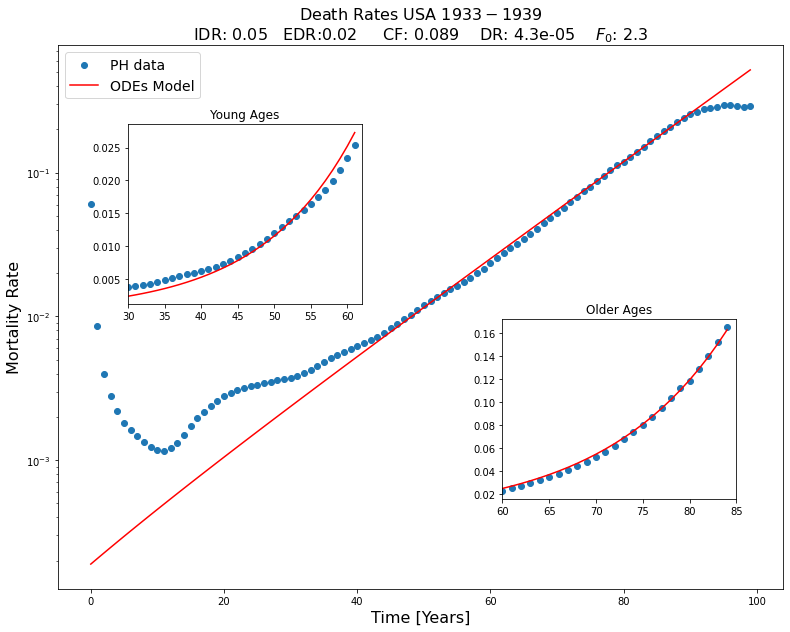

In [319]:
plt.figure(figsize=(13,10))
plt.title(r"Death Rates USA $1933-1939$" + "\n" + rf"IDR: {alpha_damage_propagation}   EDR:{disease_rate}     CF: {coupling_factor}    DR: {mortality_rate}    $F_0$: {initial_condition}" , fontsize = 16)
plt.xlabel(r"Time [Years]", fontsize = 16)
plt.ylabel(r"Mortality Rate", fontsize = 16)

zoom_ventana1 = [30, 62]  # Límites en el eje x para la primera ventana
zoom_ventana2 = [60, 85]  # Límites en el eje x para la segunda ventana


plt.scatter(datos_generales["Ages"], datos_generales["1933-1939"], label = "PH data")
plt.plot(gompertz_law_differential_equation[0:100], label = "ODEs Model", color = "red")
plt.legend(fontsize = 14)
plt.yscale("log")


ax1 = plt.axes([0.2, 0.52, 0.25, 0.25])  # Coordenadas y tamaño de la ventana 1
ax1.scatter(datos_generales["Ages"][zoom_ventana1[0]:zoom_ventana1[1]], datos_generales["1933-1939"][zoom_ventana1[0]:zoom_ventana1[1]])
ax1.plot(datos_generales["Ages"][zoom_ventana1[0]:zoom_ventana1[1]],gompertz_law_differential_equation[0:100][zoom_ventana1[0]:zoom_ventana1[1]], color = "red")
ax1.set_xlim(zoom_ventana1)


ax2 = plt.axes([0.6, 0.25, 0.25, 0.25])  # Coordenadas y tamaño de la ventana 2
ax2.scatter(datos_generales["Ages"][zoom_ventana2[0]:zoom_ventana2[1]], datos_generales["1933-1939"][zoom_ventana2[0]:zoom_ventana2[1]])
ax2.plot(datos_generales["Ages"][zoom_ventana2[0]:zoom_ventana2[1]],gompertz_law_differential_equation[0:100][zoom_ventana2[0]:zoom_ventana2[1]], color = "red")
ax2.set_xlim(zoom_ventana2)

ax1.set_title('Young Ages')
ax2.set_title('Older Ages')

plt.savefig("DR_USA_1933_1939_log_scale.jpg", dpi = 500)

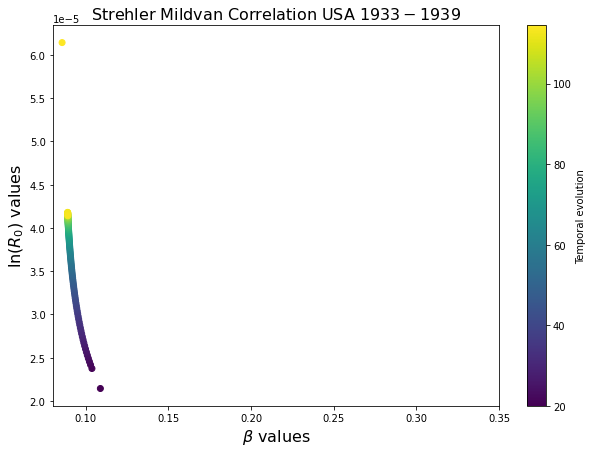

In [321]:
frailty_index = frailty_index_differential_equation[0:110]
gompertz_law = mortality_rate*(frailty_index**(coupling_factor/alpha_damage_propagation))

derivative_process = dxdt(gompertz_law, temporal_evolution_differential_equation[0:110], kind="finite_difference", k=3)
beta_values = derivative_process/gompertz_law
R_values = gompertz_law/np.e**(beta_values*temporal_evolution_differential_equation[0:110])

# Generar datos de ejemplo (reemplaza esto con tus propios datos)
tiempo = temporal_evolution_differential_equation[0:110]
x = beta_values
y = R_values
colores = tiempo

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize = (10,7))

# Crear la curva de color
scatter = ax.scatter(x, y, c=colores, cmap='viridis', marker='o')

# Crear la barra de color
norm = Normalize(vmin=min(colores), vmax=max(colores))
cbar = plt.colorbar(ScalarMappable(norm=norm, cmap='viridis'), ax=ax)
cbar.set_label('Temporal evolution')

# Etiquetas y título
ax.set_xlabel(rf"$\beta$ values", fontsize = 16)
ax.set_ylabel(rf"$\ln(R_0)$ values", fontsize = 16)
ax.set_title(rf"Strehler Mildvan Correlation USA $1933-1939$", fontsize = 16)
ax.set_xlim(0.08, 0.35)
plt.savefig("SM_correlation_USA_1933_1939.jpg", dpi = 1000)
plt.show()

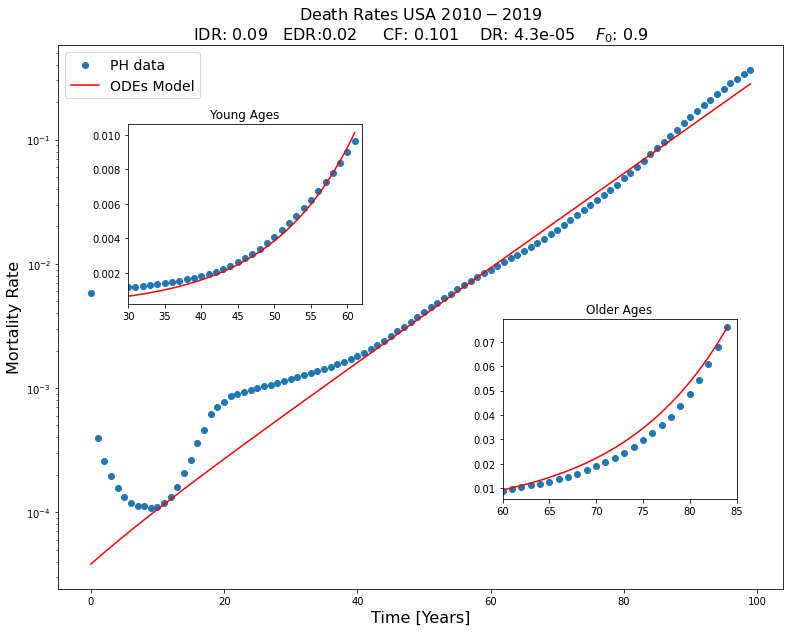

In [311]:
plt.figure(figsize=(13,10))
plt.title(r"Death Rates USA $2010-2019$" + "\n" + rf"IDR: {alpha_damage_propagation}   EDR:{disease_rate}     CF: {coupling_factor}    DR: {mortality_rate}    $F_0$: {initial_condition}" , fontsize = 16)
plt.xlabel(r"Time [Years]", fontsize = 16)
plt.ylabel(r"Mortality Rate", fontsize = 16)

zoom_ventana1 = [30, 62]  # Límites en el eje x para la primera ventana
zoom_ventana2 = [60, 85]  # Límites en el eje x para la segunda ventana


plt.scatter(datos_generales["Ages"], datos_generales["2010-2019"], label = "PH data")
plt.plot(gompertz_law_differential_equation[0:100], label = "ODEs Model", color = "red")
plt.legend(fontsize = 14)
plt.yscale("log")

ax1 = plt.axes([0.2, 0.52, 0.25, 0.25])  # Coordenadas y tamaño de la ventana 1
ax1.scatter(datos_generales["Ages"][zoom_ventana1[0]:zoom_ventana1[1]], datos_generales["2010-2019"][zoom_ventana1[0]:zoom_ventana1[1]])
ax1.plot(datos_generales["Ages"][zoom_ventana1[0]:zoom_ventana1[1]],gompertz_law_differential_equation[0:100][zoom_ventana1[0]:zoom_ventana1[1]], color = "red")
ax1.set_xlim(zoom_ventana1)


ax2 = plt.axes([0.6, 0.25, 0.25, 0.25])  # Coordenadas y tamaño de la ventana 2
ax2.scatter(datos_generales["Ages"][zoom_ventana2[0]:zoom_ventana2[1]], datos_generales["2010-2019"][zoom_ventana2[0]:zoom_ventana2[1]])
ax2.plot(datos_generales["Ages"][zoom_ventana2[0]:zoom_ventana2[1]],gompertz_law_differential_equation[0:100][zoom_ventana2[0]:zoom_ventana2[1]], color = "red")
ax2.set_xlim(zoom_ventana2)


ax1.set_title('Young Ages')
ax2.set_title('Older Ages')


plt.savefig("DR_USA_2010_2019_log_scale.jpg", dpi = 1000)